#개인 프로젝트(2주간)
- 주어진 데이터셋 중 원하는 데이터셋을 사용해 원하는 사전 훈련 모델(CNN)을 훈련시키고, 연구보고서를 작성해 보세요.
(선택은 3월 19일 수요일 13시까지)
    - (필수) Test Accuracy, Test Loss 출력 값과 성능 시각화(그래프)를 포함한 연구 및 분석 과정에 대한 내용이 있어야합니다.
    - (선택) 위 성공 조건을 달성했다면. 실제 데이터를 입력해 예측 또는 분류 결과 출력 후 분석한 내용도 작성해보세요.
    - (예고) DB 연동(중간발표후)

In [16]:
#라이브러리 설치
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from google.colab import drive

In [17]:
import os

# ✅ 구글 드라이브 데이터셋 경로
dataset_path = "/content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/PlantVillage"

# ✅ 클래스별 이미지 개수 출력 함수
def count_images_per_class(dataset_path):
    print(f"📂 기준 경로: {dataset_path}\n")
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            img_count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))  # ✅ 여기 모두 소문자
            ])
            print(f"✅ 클래스 '{class_name}': {img_count}장")

# ✅ 실행
count_images_per_class(dataset_path)

📂 기준 경로: /content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/PlantVillage

✅ 클래스 'Potato___Early_blight': 1000장
✅ 클래스 'Potato___Late_blight': 1000장
✅ 클래스 'Potato___healthy': 152장


In [9]:
# Google Drive 마운트 후 경로 확인
ORIGINAL_DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/PlantVillage"

# 파일이 실제로 있는지 확인
if os.path.exists(ORIGINAL_DATASET_PATH):
    print("✅ 데이터셋 폴더가 존재합니다.")
else:
    print("🚨 데이터셋 폴더를 찾을 수 없습니다. 경로를 다시 확인하세요.")

# 클래스 폴더 목록 확인
print("📂 클래스 폴더 목록:")
print(os.listdir(ORIGINAL_DATASET_PATH))

# 모든 `.DS_Store` 파일 삭제
for root, dirs, files in os.walk(ORIGINAL_DATASET_PATH):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"🗑️ Deleted: {file_path}")

print("✅ .DS_Store 파일 제거 완료!")

✅ 데이터셋 폴더가 존재합니다.
📂 클래스 폴더 목록:
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
✅ .DS_Store 파일 제거 완료!


In [ ]:
# 클래스별 폴더 확인 (파일이 아닌 폴더만 리스트에 추가)
categories = [category for category in os.listdir(ORIGINAL_DATASET_PATH) if os.path.isdir(os.path.join(ORIGINAL_DATASET_PATH, category))]

# 클래스 목록 출력
print(f"✅ 클래스 개수: {len(categories)}")
print(f"✅ 클래스 목록: {categories}")

✅ 클래스 개수: 3
✅ 클래스 목록: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## ❌실행조심(데이터셋 복사)

In [ ]:
# #@title
# import shutil
# import random

# # 원본 데이터 폴더 (현재 모든 이미지가 클래스별 폴더에 있음)
# ORIGINAL_DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/PlantVillage"
# NEW_DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/Split_PlantVillage(8:1:1)"

# # Train/Validation/Test 비율 설정
# TRAIN_RATIO = 0.8
# VAL_RATIO = 0.1
# TEST_RATIO = 0.1

# # 클래스 폴더 확인 (파일이 아닌 폴더만)
# categories = [category for category in os.listdir(ORIGINAL_DATASET_PATH) if os.path.isdir(os.path.join(ORIGINAL_DATASET_PATH, category))]
# print(f"✅ 클래스 개수: {len(categories)}")
# print(f"✅ 클래스 목록: {categories}")

# # 데이터 분할 수행
# for category in categories:
#     class_path = os.path.join(ORIGINAL_DATASET_PATH, category)

#     # 이미지 리스트 가져오기 (JPG, PNG만 필터링)
#     images = [img for img in os.listdir(class_path) if img.endswith(('.JPG', '.jpeg', '.png'))]
#     random.shuffle(images)

#     total_images = len(images)
#     if total_images == 0:
#         print(f"⚠️ {category} 클래스에 이미지가 없습니다. 복사할 파일이 없습니다.")
#         continue

#     train_size = int(total_images * TRAIN_RATIO)
#     val_size = int(total_images * VAL_RATIO)

#     train_images = images[:train_size]
#     val_images = images[train_size:train_size + val_size]
#     test_images = images[train_size + val_size:]

#     # 폴더 생성 (존재하지 않으면 생성)
#     os.makedirs(os.path.join(NEW_DATASET_PATH, "train", category), exist_ok=True)
#     os.makedirs(os.path.join(NEW_DATASET_PATH, "val", category), exist_ok=True)
#     os.makedirs(os.path.join(NEW_DATASET_PATH, "test", category), exist_ok=True)

#     # 이미지 복사 (Train)
#     for img in train_images:
#         shutil.copy2(os.path.join(class_path, img), os.path.join(NEW_DATASET_PATH, "train", category, img))

#     # 이미지 복사 (Validation)
#     for img in val_images:
#         shutil.copy2(os.path.join(class_path, img), os.path.join(NEW_DATASET_PATH, "val", category, img))

#     # 이미지 복사 (Test)
#     for img in test_images:
#         shutil.copy2(os.path.join(class_path, img), os.path.join(NEW_DATASET_PATH, "test", category, img))

#     print(f"✅ {category}: Train {len(train_images)}, Val {len(val_images)}, Test {len(test_images)}")

# print("✅ 데이터 분할 완료! 폴더가 정상적으로 생성되었습니다.")


In [ ]:
# 데이터 확인
Split_DATASET_PATH = "//content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/Split_PlantVillage(8:1:1)"

for phase in ["train", "val", "test"]:
    print(f"📂 {phase} 데이터")
    for category in os.listdir(os.path.join(Split_DATASET_PATH, phase)):
        num_images = len(os.listdir(os.path.join(Split_DATASET_PATH, phase, category)))
        print(f"   - {category}: {num_images} images")

📂 train 데이터
   - Potato___Late_blight: 957 images
   - Potato___Early_blight: 960 images
   - Potato___healthy: 147 images
📂 val 데이터
   - Potato___Late_blight: 190 images
   - Potato___Early_blight: 191 images
   - Potato___healthy: 28 images
📂 test 데이터
   - Potato___Late_blight: 188 images
   - Potato___Early_blight: 188 images
   - Potato___healthy: 32 images


In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# ✅ 데이터셋 경로 설정
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/Split_PlantVillage(8:1:1)"

# ✅ 훈련 데이터에 데이터 증강 추가
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # 중심 크롭 후 224x224 변환
    transforms.RandomHorizontalFlip(),  # 좌우 반전
    transforms.RandomRotation(15),  # 15도 이내 랜덤 회전
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5),  # 50% 확률로 색감 변환
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # 이동, 확대/축소
    transforms.GaussianBlur(kernel_size=3),  # 블러 효과 추가
    transforms.ToTensor(), # Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ 검증 & 테스트 데이터는 원본 유지
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ 데이터셋 로드 (훈련 데이터에는 증강 적용)
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=val_test_transform)

# ✅ 데이터 로더 생성
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)  # 🔥 훈련 데이터는 섞음
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)  # 검증 데이터는 유지
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)  # 테스트 데이터도 유지

# ✅ 데이터셋 개수 확인
print(f"✅ 훈련 데이터 개수: {len(train_dataset)}")
print(f"✅ 검증 데이터 개수: {len(val_dataset)}")
print(f"✅ 테스트 데이터 개수: {len(test_dataset)}")

# ✅ 클래스 정보 출력
print(f"✅ 클래스 개수: {len(train_dataset.classes)}")
print(f"✅ 클래스 목록: {train_dataset.classes}")


✅ 훈련 데이터 개수: 2064
✅ 검증 데이터 개수: 409
✅ 테스트 데이터 개수: 408
✅ 클래스 개수: 3
✅ 클래스 목록: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## ResNet50 모델 불러오기 및 수정

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# ✅ 사전 학습된 ResNet 모델 불러오기
model = models.resnet50(pretrained=True)  # ResNet50 사용 (ResNet18, ResNet34도 가능)

# ✅ 특징 추출기(Frozen) 설정 (Conv 레이어들은 고정)
for param in model.parameters():
    param.requires_grad = False  # 기존 CNN 부분은 학습 X (고정)

# ✅ 마지막 FC 레이어 수정 (현재 감자 병해 클래스 개수에 맞춤)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 새로운 Fully Connected Layer 추가

# ✅ 모델을 GPU로 이동 (CUDA 사용 가능하면)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)  # 변경된 모델 구조 확인

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 모델 학습 설정(손실함수 & 옵티마이저 설정)

In [ ]:
# ✅ 손실 함수 (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# ✅ 옵티마이저 (Fully Connected Layer만 학습)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# ✅ 학습률 감소 스케줄러 (매 7 Epoch마다 0.1배 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## 모델 학습 (Training Loop)

	1.	모델을 학습 모드(model.train()) 로 설정
	2.	train_loader에서 배치를 하나씩 불러와서 학습
	3.	손실을 계산하고, optimizer.step()으로 가중치 업데이트
	4.	val_loader를 사용하여 검증
	5.	scheduler.step()을 호출하여 학습률 감소 적용

In [ ]:
import os
import numpy as np
import torch

best_model_path = "/content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/ ResNet50_Best_Model(8:1:1).pth"


# ✅ 얼리 스탑 설정
patience = 5  # 🔥 5 에포크 동안 개선이 없으면 중단
min_delta = 0.001  # 🔥 개선이 min_delta 이하이면 의미 없는 개선으로 간주
best_val_loss = np.inf  # 처음에는 무한대로 설정
counter = 0  # 개선되지 않은 횟수 카운트

EPOCHS = 50  # 최대 50 에포크까지 학습

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# ✅ 모델 평가 함수 (오류 해결)
def evaluate(model, dataloader):
    model.eval()  # 평가 모드로 변경
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # 그래디언트 계산 비활성화 (속도 최적화)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    # 학습 손실 및 정확도 계산
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 검증 손실 및 정확도 계산
    val_loss, val_acc = evaluate(model, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # 현재 학습률 확인
    current_lr = optimizer.param_groups[0]['lr']

    # 로그 출력
    print(f"\n📘 Epoch [{epoch+1}/{EPOCHS}]")
    print(f"   🔹 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   🔸 Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print(f"   📉 Learning Rate: {current_lr:.6f}")


    # 얼리 스탑 확인
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"   ✅ 성능 향상! 모델 저장됨: {best_model_path}")
    else:
        counter += 1
        print(f"   ⏳ 개선 없음 (Counter: {counter}/{patience})")

    # 얼리 스탑 조건 충족 시 학습 중단
    if counter >= patience:
        print(f"\n🚨 얼리 스탑 발생! {epoch+1} 에포크에서 학습 종료 🚨")
        break

    # 학습률 스케줄러 업데이트
    scheduler.step()


📘 Epoch [1/50]
   🔹 Train Loss: 0.5879 | Train Acc: 77.81%
   🔸 Val   Loss: 0.4269 | Val   Acc: 85.82%
   📉 Learning Rate: 0.001000
   ✅ 성능 향상! 모델 저장됨: /content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/ ResNet50_Best_Model(8:1:1).pth

📘 Epoch [2/50]
   🔹 Train Loss: 0.3817 | Train Acc: 85.17%
   🔸 Val   Loss: 0.3259 | Val   Acc: 86.06%
   📉 Learning Rate: 0.001000
   ✅ 성능 향상! 모델 저장됨: /content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/ ResNet50_Best_Model(8:1:1).pth

📘 Epoch [3/50]
   🔹 Train Loss: 0.2993 | Train Acc: 88.86%
   🔸 Val   Loss: 0.2011 | Val   Acc: 94.13%
   📉 Learning Rate: 0.001000
   ✅ 성능 향상! 모델 저장됨: /content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/[카카오 부트캠프] 개인과제2 폴더/ ResNet50_Best_Model(8:1:1).pth

📘 Epoch [4/50]
   🔹 Train Loss: 0.2700 | Train Acc: 89.87%
   🔸 Val   Loss: 0.1817 | Val   Acc: 94.87%
   📉 Learning Rate: 0.001000
   ✅ 성능 향상! 모델 저장됨: /content/d

## 모델 저장(가중치 & 전체모델)

In [ ]:
# # ✅ 구글 드라이브 내 모델 저장 경로 설정

# SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/[카카오 부트캠프]/Saved_Model(8:1:1)"
# os.makedirs(SAVE_DIR, exist_ok=True)  # 폴더가 없으면 생성

# # ✅ 학습이 끝난 후 가장 좋은 모델을 다시 저장 (가중치 & 전체 모델)
# torch.save(torch.load(best_model_path), os.path.join(SAVE_DIR, "resnet_model_weights(8:1:1).pt"))
# print(f"✅ 최종 모델 가중치 저장 완료: {os.path.join(SAVE_DIR, 'resnet_model_weights(8:1:1).pt')}")

# torch.save(model, os.path.join(SAVE_DIR, "resnet_full_model(8:1:1).pth"))
# print(f"✅ 최종 모델 전체 저장 완료: {os.path.join(SAVE_DIR, 'resnet_full_model(8:1:1).pth')}")

## 모델 시각화

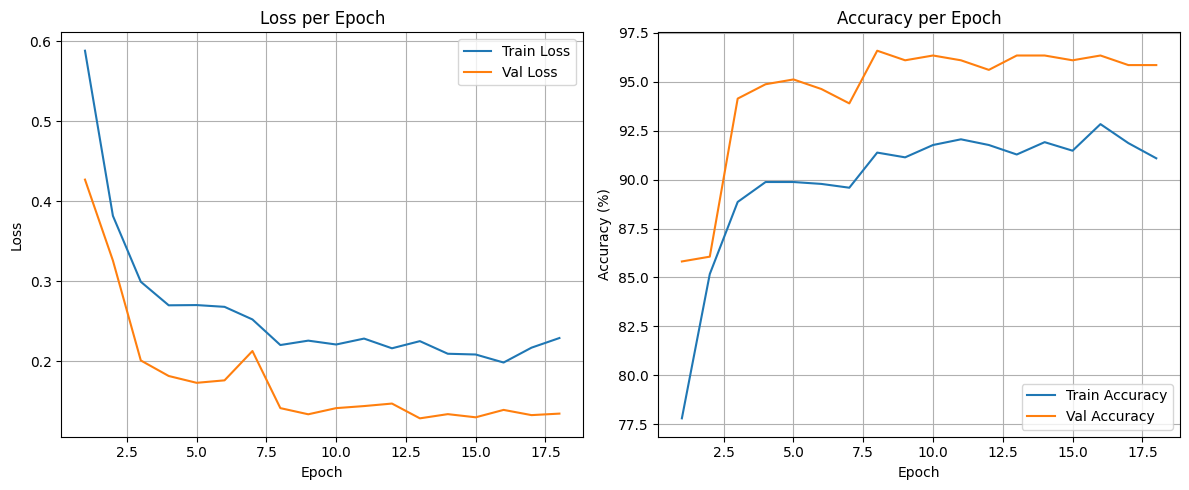

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# 🔹 손실(Loss) 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 🔸 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


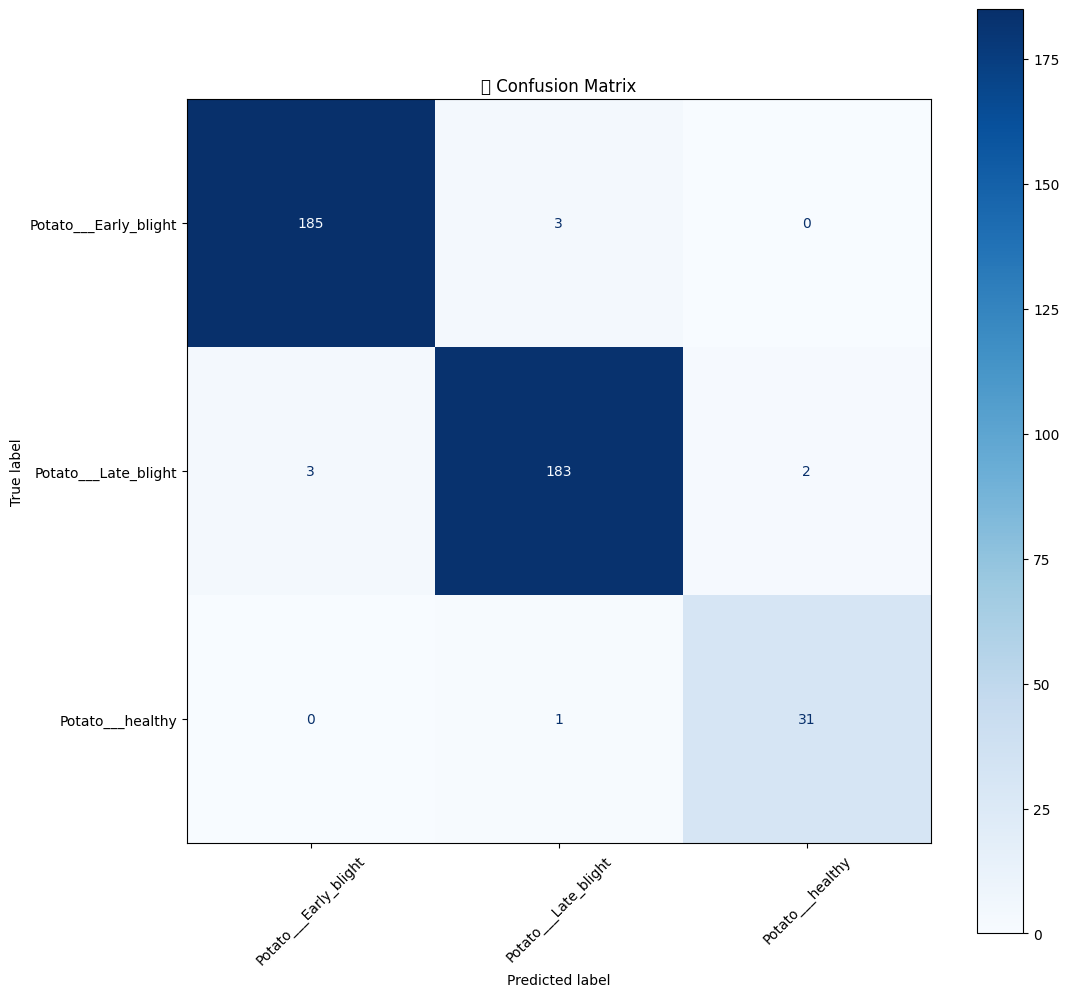

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 모델 로드
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 전체 예측 결과 수집
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

# 시각화
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
plt.title("🧩 Confusion Matrix")
plt.show()

## 잘못 분류된 이미지 시각화
    - 20개씩 페이지별로 보기

총 잘못 분류된 이미지 수: 9


<ipython-input-40-7253f20fa96f>:33: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-7253f20fa96f>:33: UserWarning: Glyph 51096 (\N{HANGUL SYLLABLE JAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-7253f20fa96f>:33: UserWarning: Glyph 47803 (\N{HANGUL SYLLABLE MOS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-7253f20fa96f>:33: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-7253f20fa96f>:33: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-7253f20fa96f>:33: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-40-7253f20fa96f>:33: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-4

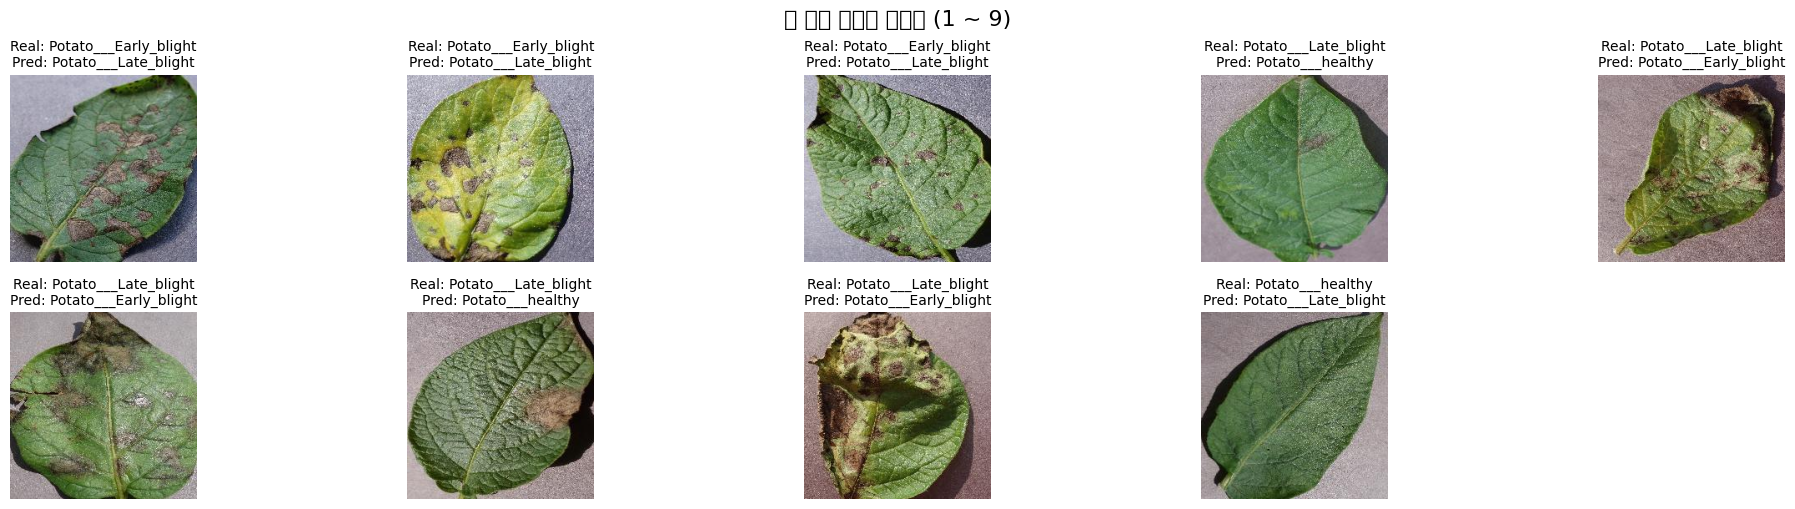

In [ ]:
def show_all_misclassified_images(model, dataloader, class_names, images_per_page=20):
    model.eval()
    misclassified_images = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified_images.append((img.cpu(), label.cpu(), pred.cpu()))

    total = len(misclassified_images)
    print(f"총 잘못 분류된 이미지 수: {total}")

    # 여러 페이지에 걸쳐 시각화
    for start in range(0, total, images_per_page):
        end = min(start + images_per_page, total)
        plt.figure(figsize=(20, 10))
        for i in range(start, end):
            img, label, pred = misclassified_images[i]
            img = img.permute(1, 2, 0).numpy()
            img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Normalize 해제
            img = np.clip(img, 0, 1)

            plt.subplot(4, 5, i - start + 1)
            plt.imshow(img)
            plt.title(f"Real: {class_names[label]}\nPred: {class_names[pred]}", fontsize=10)
            plt.axis('off')
        plt.suptitle(f"❌ 잘못 분류된 이미지 ({start+1} ~ {end})", fontsize=16)
        plt.tight_layout()
        plt.show()

# 호출
show_all_misclassified_images(model, test_loader, train_dataset.classes)

## 클래스별 정확도 출력

In [ ]:
from sklearn.metrics import classification_report

print("📊 클래스별 성능 요약")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

📊 클래스별 성능 요약
                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.98      0.98       188
 Potato___Late_blight       0.98      0.97      0.98       188
     Potato___healthy       0.94      0.97      0.95        32

             accuracy                           0.98       408
            macro avg       0.97      0.98      0.97       408
         weighted avg       0.98      0.98      0.98       408



## 모델 학습 후 Test Accuracy, Test Loss 출력

In [ ]:
import matplotlib.pyplot as plt

# ✅ 모델 평가 함수
def evaluate(model, dataloader):
    model.eval()  # 평가 모드
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # 그래디언트 계산 X (속도 최적화)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

# ✅ 최종 테스트 데이터 평가
test_loss, test_acc = evaluate(model, test_loader)

print(f"🔥 최종 테스트 결과 🔥")
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.2f}%")

🔥 최종 테스트 결과 🔥
✅ Test Loss: 0.1191
✅ Test Accuracy: 97.79%
